In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


TODO:
- Selecting the 1972-2018 period for quantile bias correction isn't great (the obs sample is too small for calculating robust quantiles), so we need to use all the data. This probably means we need to de-trend the data first.

In [3]:
mildura_lat = -34.2
mildura_lon = 142.1

### Observations

In [4]:
#txx_obs_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'

In [5]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [6]:
da_obs = ds_obs['tasmax'].sel({'lat': mildura_lat, 'lon': mildura_lon}, method='nearest')

In [7]:
da_obs = da_obs.compute()

In [8]:
df_obs = da_obs.to_dataframe()

In [9]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
1990-06-30 00:00:00 -34.0  142.0  1990-01-03  48.070168
1939-06-30 00:00:00 -34.0  142.0  1939-01-10  47.354195
2001-06-30 00:00:00 -34.0  142.0  2001-01-14  47.192989
2020-06-30 00:00:00 -34.0  142.0  2019-12-20  46.924156
2019-06-30 00:00:00 -34.0  142.0  2019-01-04  46.915867
1979-06-30 00:00:00 -34.0  142.0  1979-01-14  46.859818
2017-06-30 00:00:00 -34.0  142.0  2017-02-10  46.850529
2009-06-30 00:00:00 -34.0  142.0  2009-02-07  46.835129
1932-06-30 00:00:00 -34.0  142.0  1932-01-27  46.403103
1982-06-30 00:00:00 -34.0  142.0  1982-01-24  46.376907


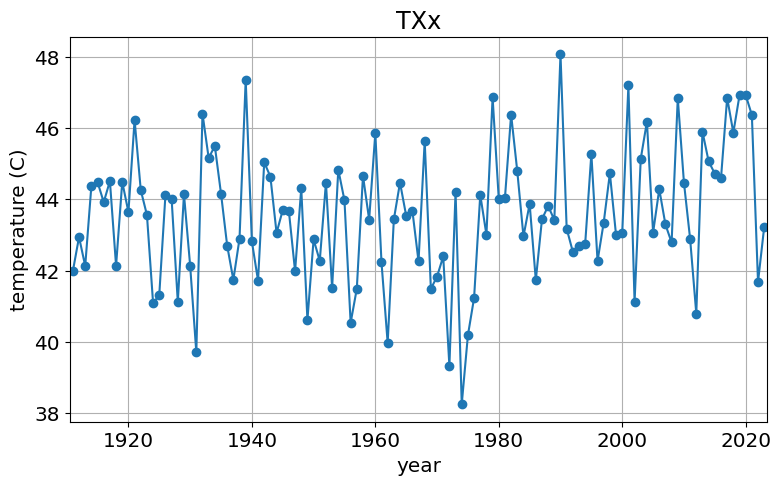

In [10]:
fig, ax = plt.subplots(figsize=[9, 5])
values = da_obs.values
years = da_obs['time'].dt.year.values
plt.plot(years, values, marker='o')
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.grid()

In [11]:
gev_shape_obs, gev_loc_obs, gev_scale_obs = eva.fit_gev(da_obs.values)
print(f'Shape parameter: {gev_shape_obs:.2f}')
print(f'Location parameter: {gev_loc_obs:.2f}')
print(f'Scale parameter: {gev_scale_obs:.2f}')

Shape parameter: 0.30
Location parameter: 42.93
Scale parameter: 1.89


### Model data

In [12]:
#txx_model_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'

In [13]:
ds_model = fileio.open_dataset(txx_model_file)

In [14]:
da_model = ds_model['tasmax'].sel({'lat': mildura_lat, 'lon': mildura_lon}, method='nearest')

In [15]:
da_model = da_model.compute()

In [16]:
help(stability.create_plot)

Help on function create_plot in module unseen.stability:

create_plot(
    da_fcst,
    metric,
    start_years,
    outfile=None,
    uncertainty=False,
    ylim=None,
    units=None,
    return_method='empirical',
    ensemble_dim='ensemble',
    init_dim='init_date',
    lead_dim='lead_time'
)
    Create a stability assessment plot.

    Parameters
    ----------
    da_fcst : xarray Data Array
        Forecast data
    metric: str
        Metric name (for plot title)
    start_years : list
        Equally spaced list of start years
    outfile : str, default None
        Path for output image file
    uncertainty: bool, default False
        Plot the 95% confidence interval
    ylim : tuple, optional
        y axis limits for return curve plots [min, max]
    units : str, optional
        units for plot axis labels
    return_method : {'empirical', 'gev'}, default empirial
        Method for fitting the return period curve
    ensemble_dim : str, default ensemble
        Name of en

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


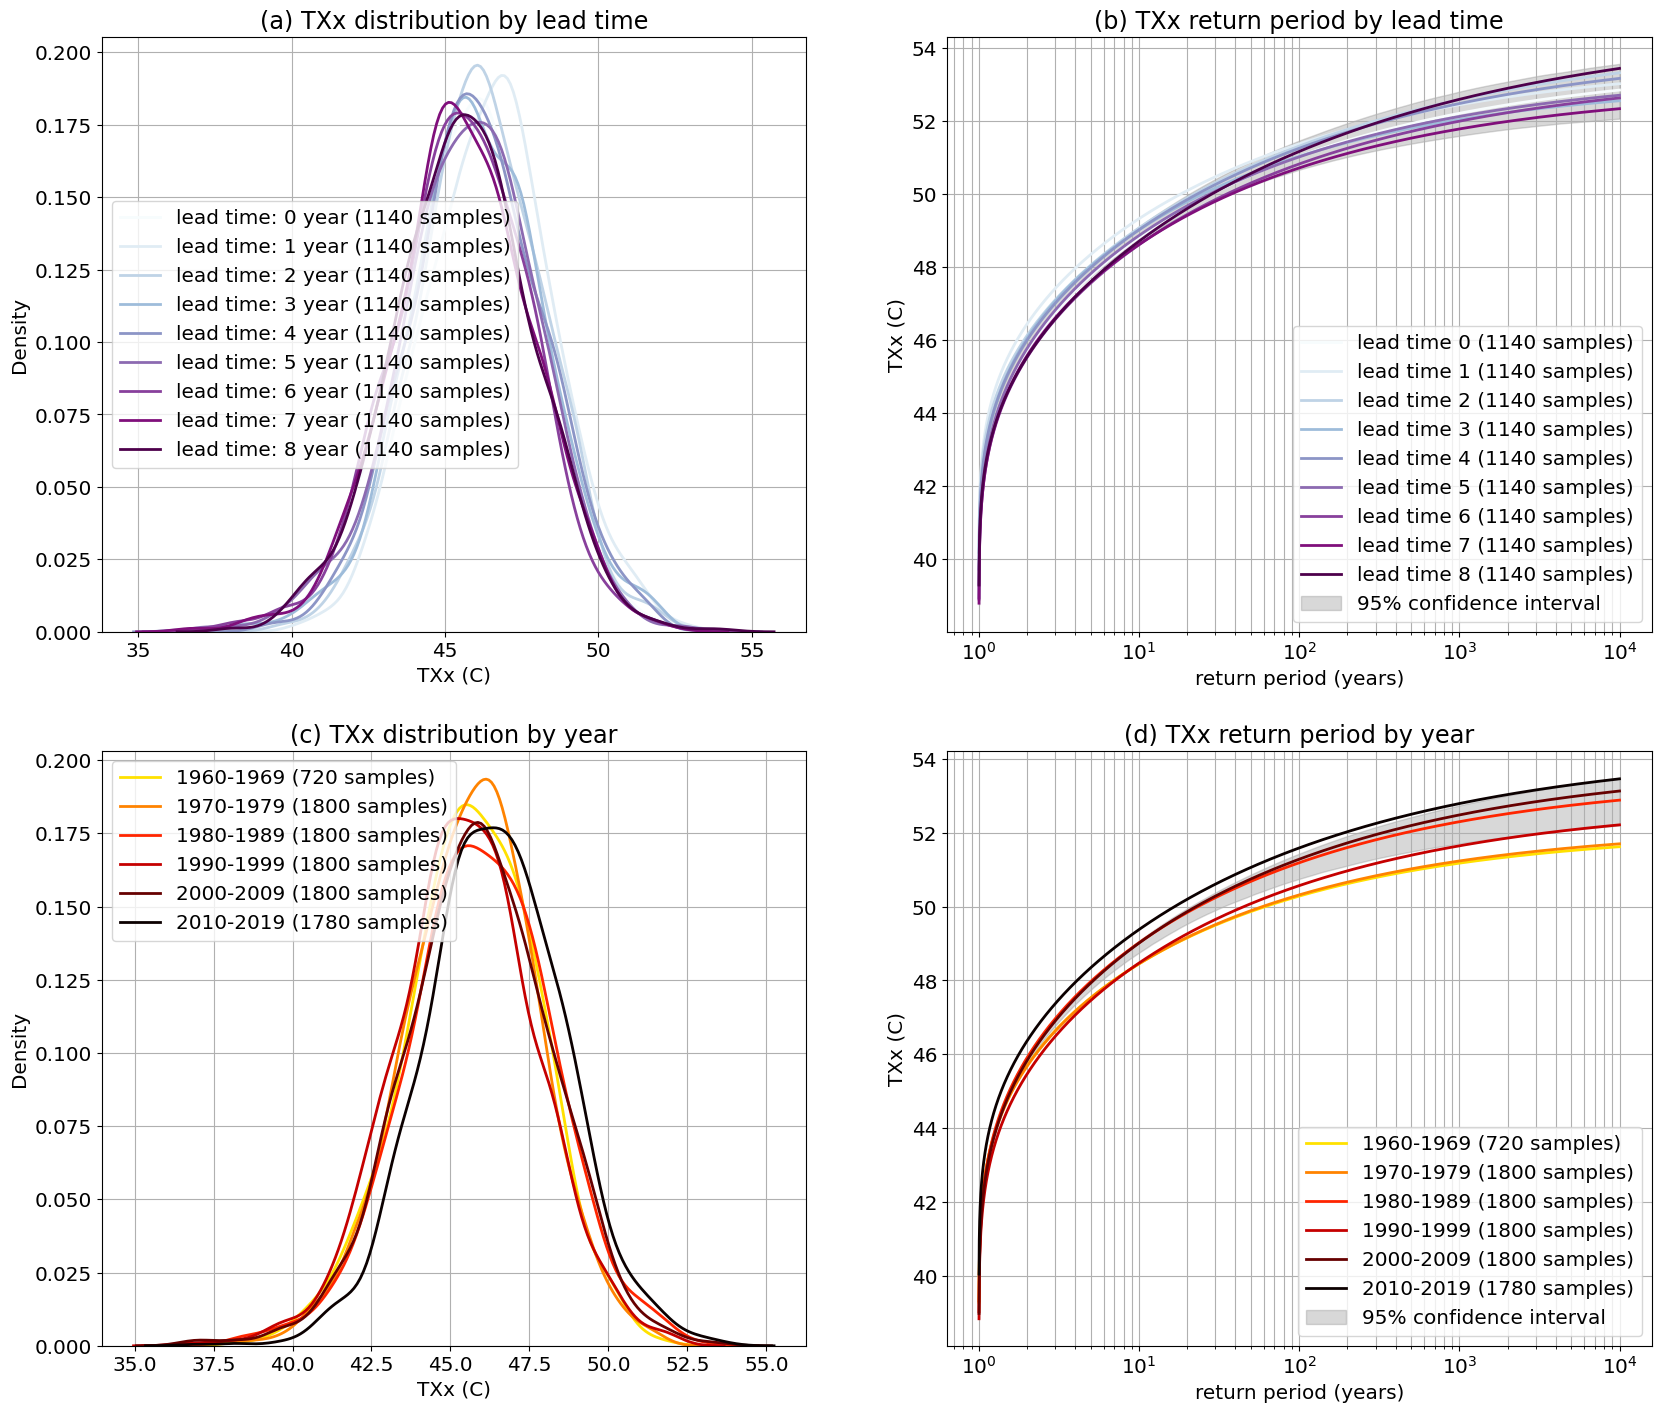

In [17]:
stability.create_plot(
    da_model,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

In [15]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [16]:
gev_shape_model, gev_loc_model, gev_scale_model = eva.fit_gev(da_model_stacked.values)
print(f'Shape parameter: {gev_shape_model:.2f}')
print(f'Location parameter: {gev_loc_model:.2f}')
print(f'Scale parameter: {gev_scale_model:.2f}')

Shape parameter: 0.25
Location parameter: 45.05
Scale parameter: 2.27


### Mean correction

#### Additive

In [17]:
bias_mean_add = bias_correction.get_bias(
    da_model,
    da_obs,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [18]:
da_model_bc_mean_add = bias_correction.remove_bias(da_model, bias_mean_add, 'additive')

In [19]:
da_model_bc_mean_add = da_model_bc_mean_add.compute()

In [20]:
da_model_bc_mean_add_stacked = da_model_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
gev_shape_model_bc_mean_add, gev_loc_model_bc_mean_add, gev_scale_model_bc_mean_add = eva.fit_gev(da_model_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_mean_add:.2f}')

Shape parameter: 0.25
Location parameter: 42.97
Scale parameter: 2.27


#### Multiplicative

In [22]:
bias_mean_mulc = bias_correction.get_bias(
    da_model,
    da_obs,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [23]:
da_model_bc_mean_mulc = bias_correction.remove_bias(da_model, bias_mean_mulc, 'additive')
da_model_bc_mean_mulc = da_model_bc_mean_mulc.compute()

In [24]:
da_model_bc_mean_mulc_stacked = da_model_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
gev_shape_model_bc_mean_mulc, gev_loc_model_bc_mean_mulc, gev_scale_model_bc_mean_mulc = eva.fit_gev(da_model_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_mean_mulc:.2f}')

Shape parameter: 0.25
Location parameter: 44.00
Scale parameter: 2.27


### Quantile correction

In [26]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [27]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [28]:
da_model_q = nbutils.quantile(
    da_model_stacked,
    quantile_array,
    ['sample']
)

# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [29]:
da_model_q.values

array([42.192577, 43.621677, 44.476234, 45.078236, 45.63127 , 46.17791 ,
       46.746624, 47.3693  , 48.15235 , 49.442856], dtype=float32)

In [30]:
da_obs_q = nbutils.quantile(
    da_obs,
    quantile_array,
    ['time']
)

# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [31]:
da_obs_q.values

array([40.579037, 41.70889 , 42.267696, 42.904892, 43.374233, 43.8482  ,
       44.247734, 44.635292, 45.52076 , 46.854244], dtype=float32)

In [32]:
bias_quantile_add = da_model_q.values - da_obs_q.values

In [33]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

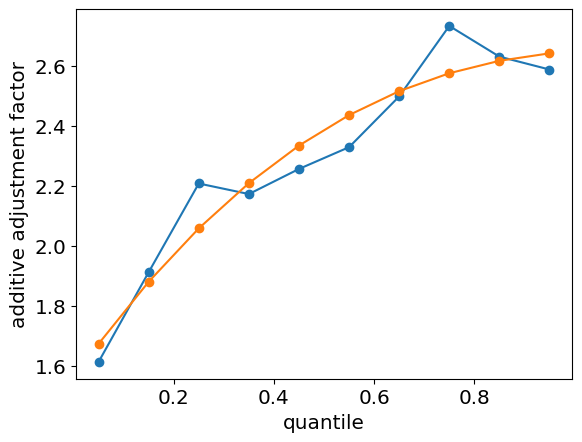

In [34]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [35]:
bias_quantile_mulc = da_model_q.values / da_obs_q.values

In [36]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

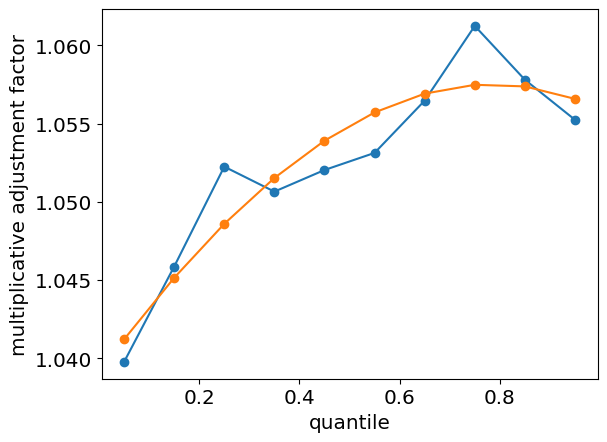

In [37]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [38]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [39]:
#af_add = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_add,
#)
af_add = vget_smooth_adjustment_factor(
    da_model_stacked.values,
    data=da_model_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [40]:
da_model_bc_quantile_add = da_model_stacked - af_add

In [41]:
gev_shape_model_bc_quantile_add, gev_loc_model_bc_quantile_add, gev_scale_model_bc_quantile_add = eva.fit_gev(da_model_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_quantile_add:.2f}')

Shape parameter: 0.22
Location parameter: 42.85
Scale parameter: 1.95


#### Multiplicative

In [42]:
#af_mulc = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_mulc,
#)
af_mulc = vget_smooth_adjustment_factor(
    da_model_stacked.values,
    data=da_model_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [43]:
da_model_bc_quantile_mulc = da_model_stacked / af_mulc

In [44]:
gev_shape_model_bc_quantile_mulc, gev_loc_model_bc_quantile_mulc, gev_scale_model_bc_quantile_mulc = eva.fit_gev(da_model_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_quantile_mulc:.2f}')

Shape parameter: 0.23
Location parameter: 42.86
Scale parameter: 1.94


## Comparison

In [45]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model,
        da_obs,
        da_bc_fcst=da_target,
    )

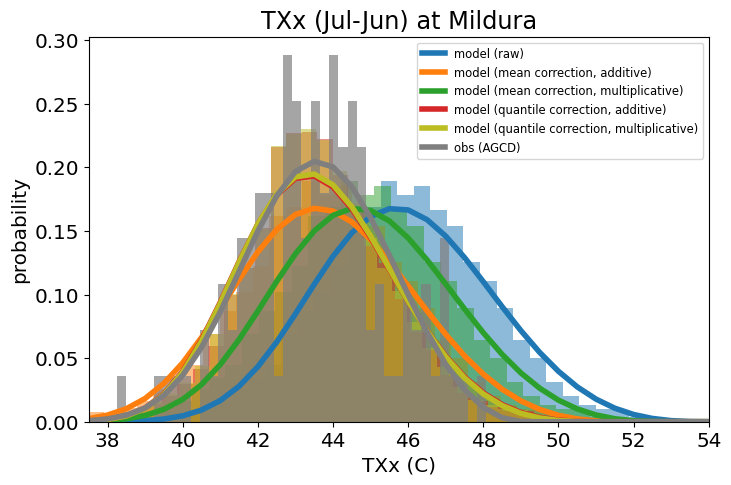

In [54]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(30, 65, 0.5)

da_model_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model = gev.pdf(gev_xvals, gev_shape_model, gev_loc_model, gev_scale_model)
plt.plot(gev_xvals, gev_pdf_model, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_mean_add,
    gev_loc_model_bc_mean_add,
    gev_scale_model_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_mean_mulc,
    gev_loc_model_bc_mean_mulc,
    gev_scale_model_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_quantile_add,
    gev_loc_model_bc_quantile_add,
    gev_scale_model_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_bc_quantile_mulc,
    gev_loc_model_bc_quantile_mulc,
    gev_scale_model_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs = gev.pdf(gev_xvals, gev_shape_obs, gev_loc_obs, gev_scale_obs)
plt.plot(gev_xvals, gev_pdf_obs, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at Mildura')
plt.xlim(37.5, 54)
plt.legend(fontsize='small')
plt.savefig('txx_mildura_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [47]:
similarity_ds = similarity.similarity_tests(da_model, da_obs)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.4875908
KS p-value: 4.6272845e-25
AD score: 81.58321
AD p-value: 0.001


### Additive - mean correction

KS score: 0.116772756
KS p-value: 0.08692746
AD score: 0.79016525
AD p-value: 0.15519488


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.463247776031494 to 46.24841499328613
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.9211595058441162 to 2.5180983424186705
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.7068583264946937 to 0.4179644502699375
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5950660467147827 to 1.90962975025177
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.15973090482173305 to 0.44093248092602355
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      f

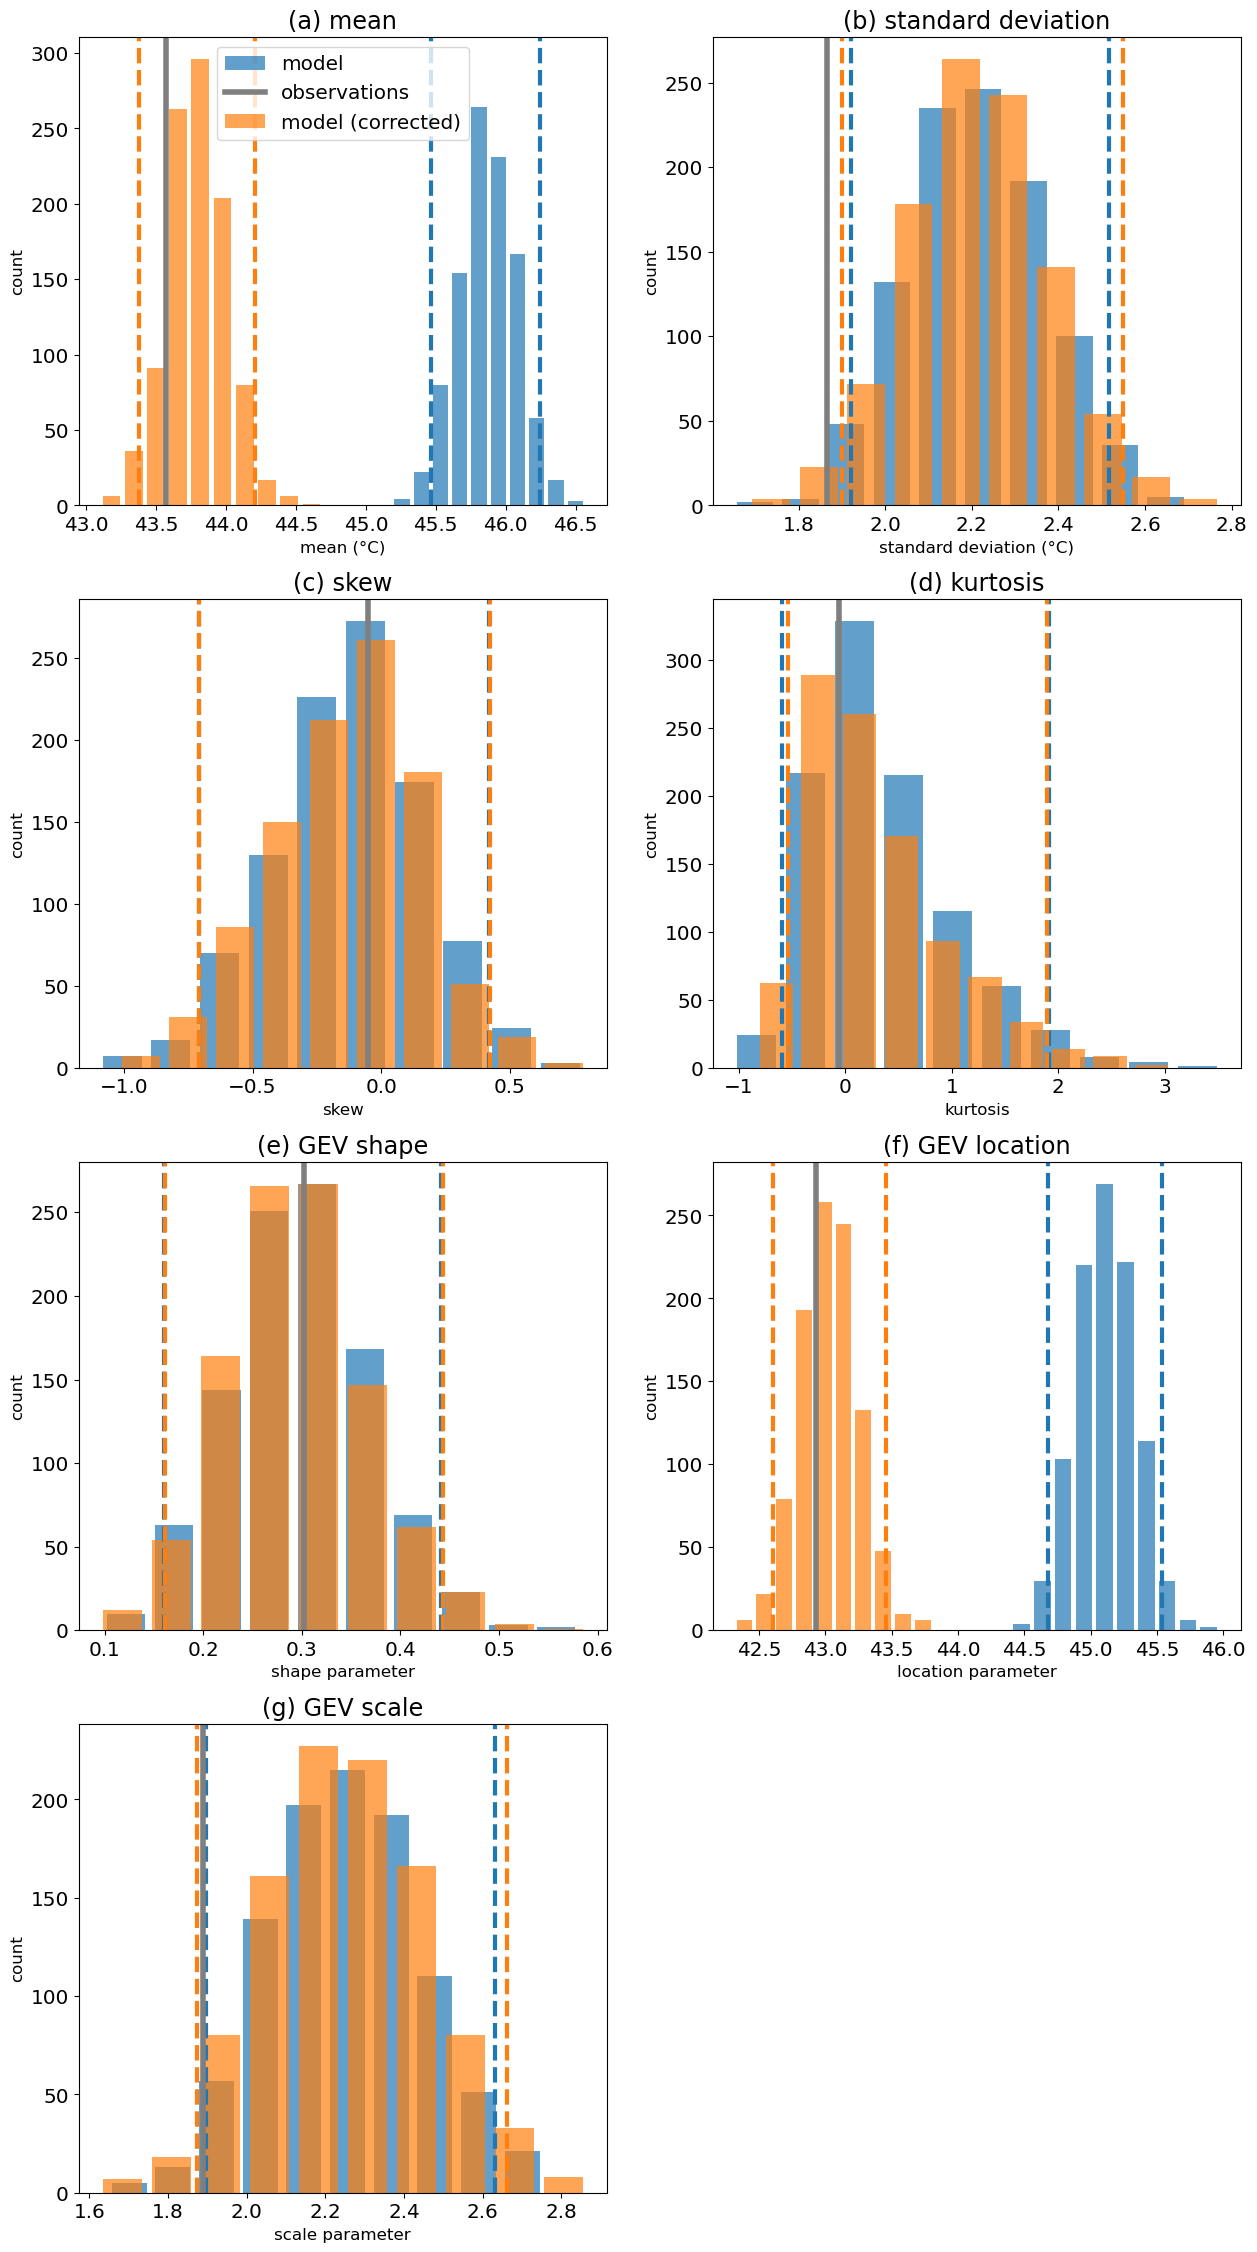

In [48]:
fidelity_tests(da_model_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.30221066
KS p-value: 1.4292246e-09
AD score: 25.51588
AD p-value: 0.001


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.50064315795898 to 46.283258247375485
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.888200396299362 to 2.5355925798416137
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.6823799639940262 to 0.3844076484441757
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5888449668884277 to 1.7951039314270008
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.17093285460495367 to 0.4415342778354585
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      f

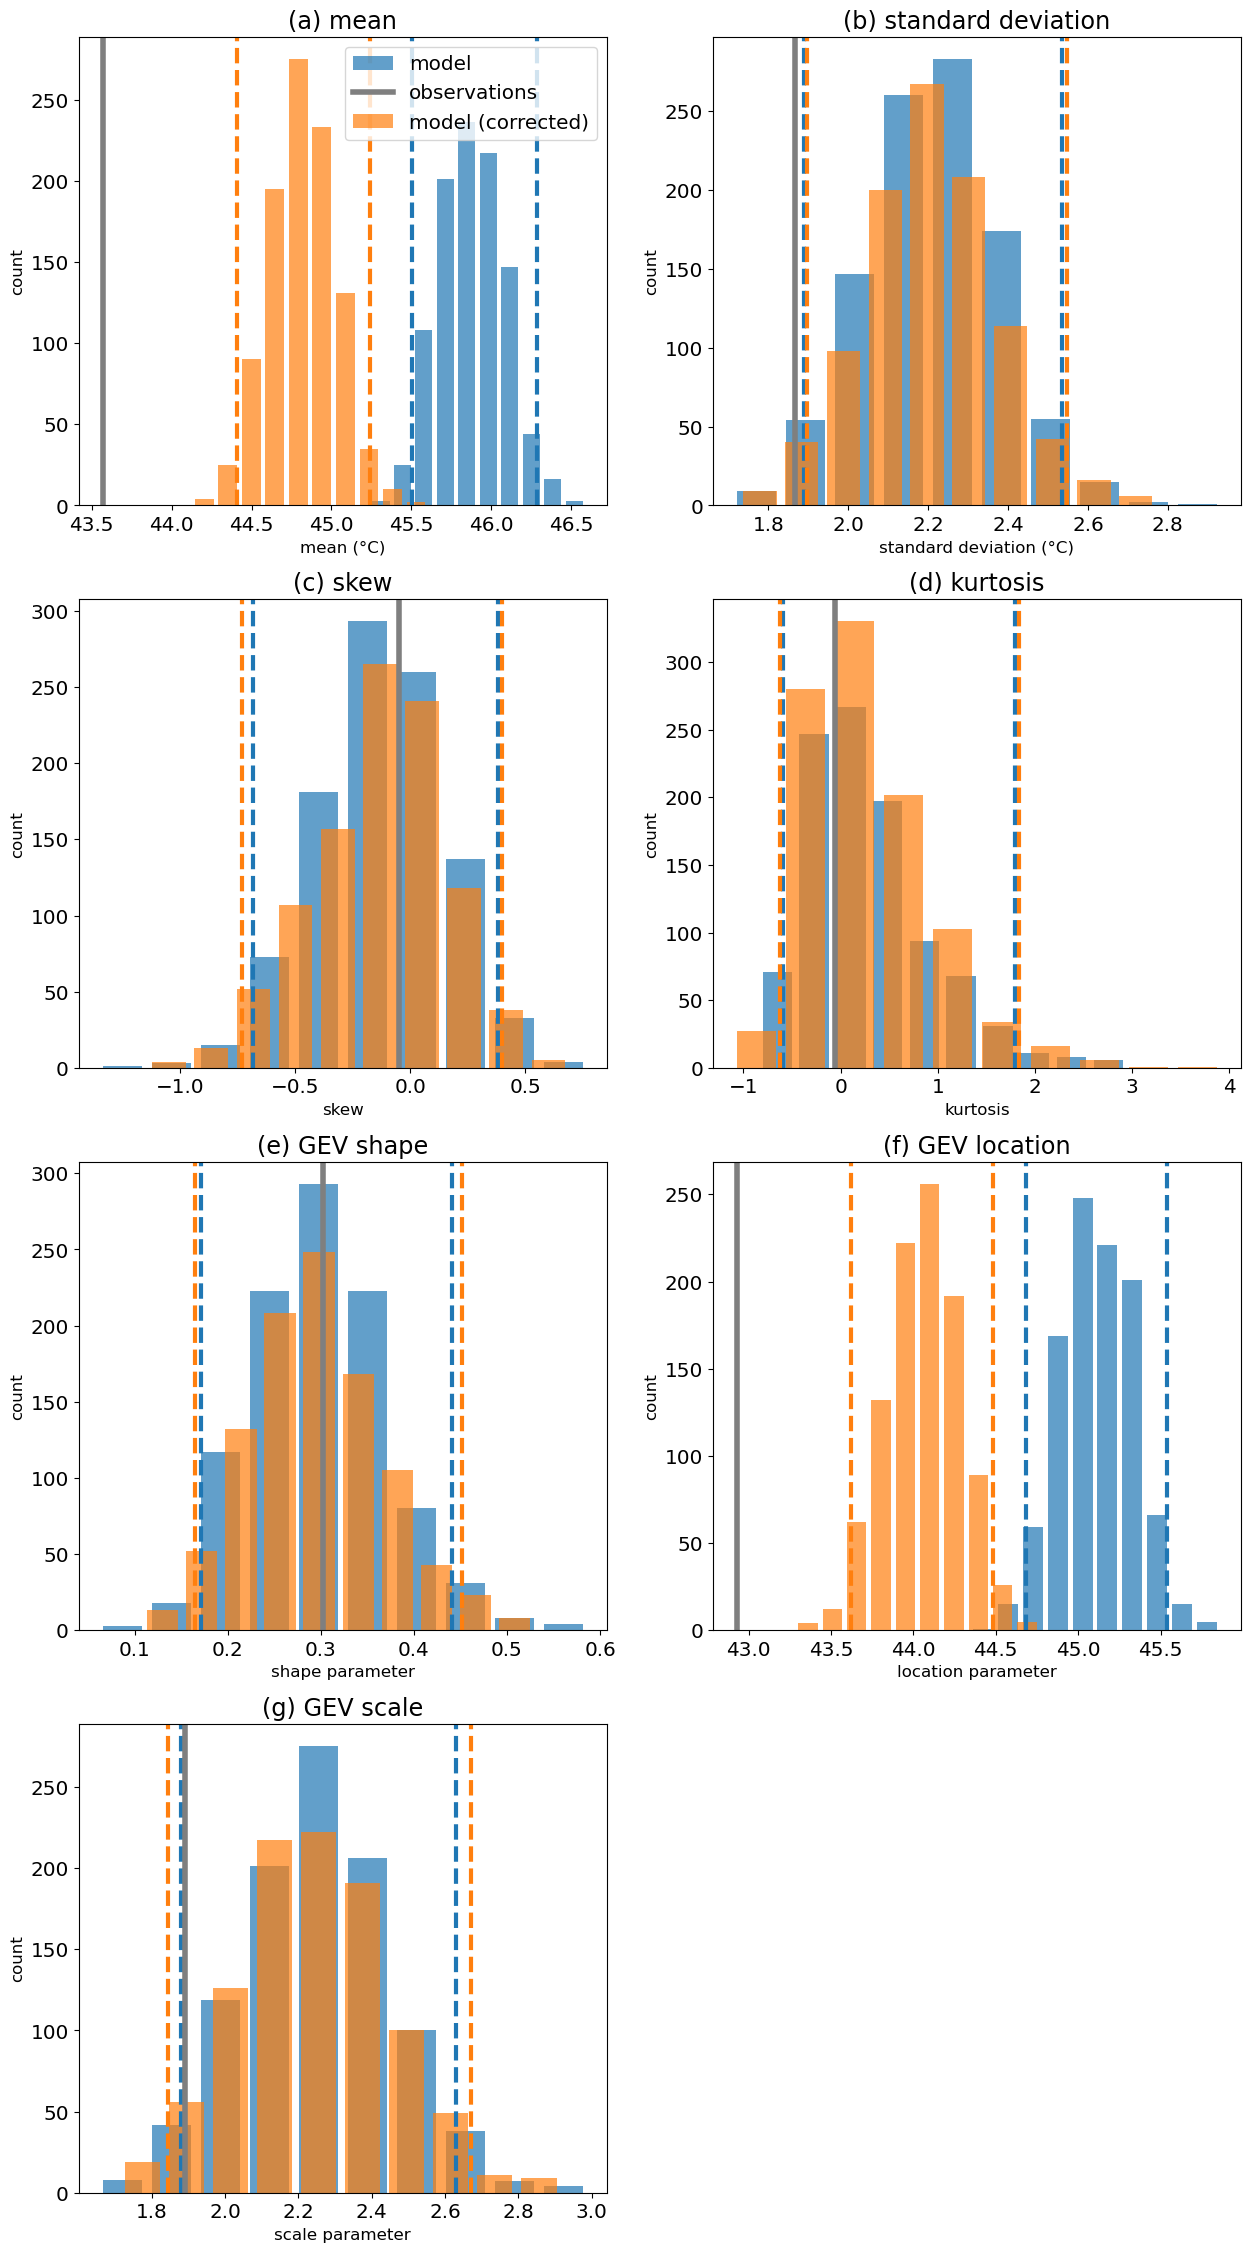

In [49]:
fidelity_tests(da_model_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.041899983
KS p-value: 0.98475784
AD score: -1.0352926
AD p-value: 0.25


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.49812459945679 to 46.29339189529419
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.89673510491848 to 2.5190204858779905
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.6674385711550712 to 0.3777538321912289
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5735026001930237 to 1.6983995914459225
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.17558259599401696 to 0.45430704811392525
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      fl

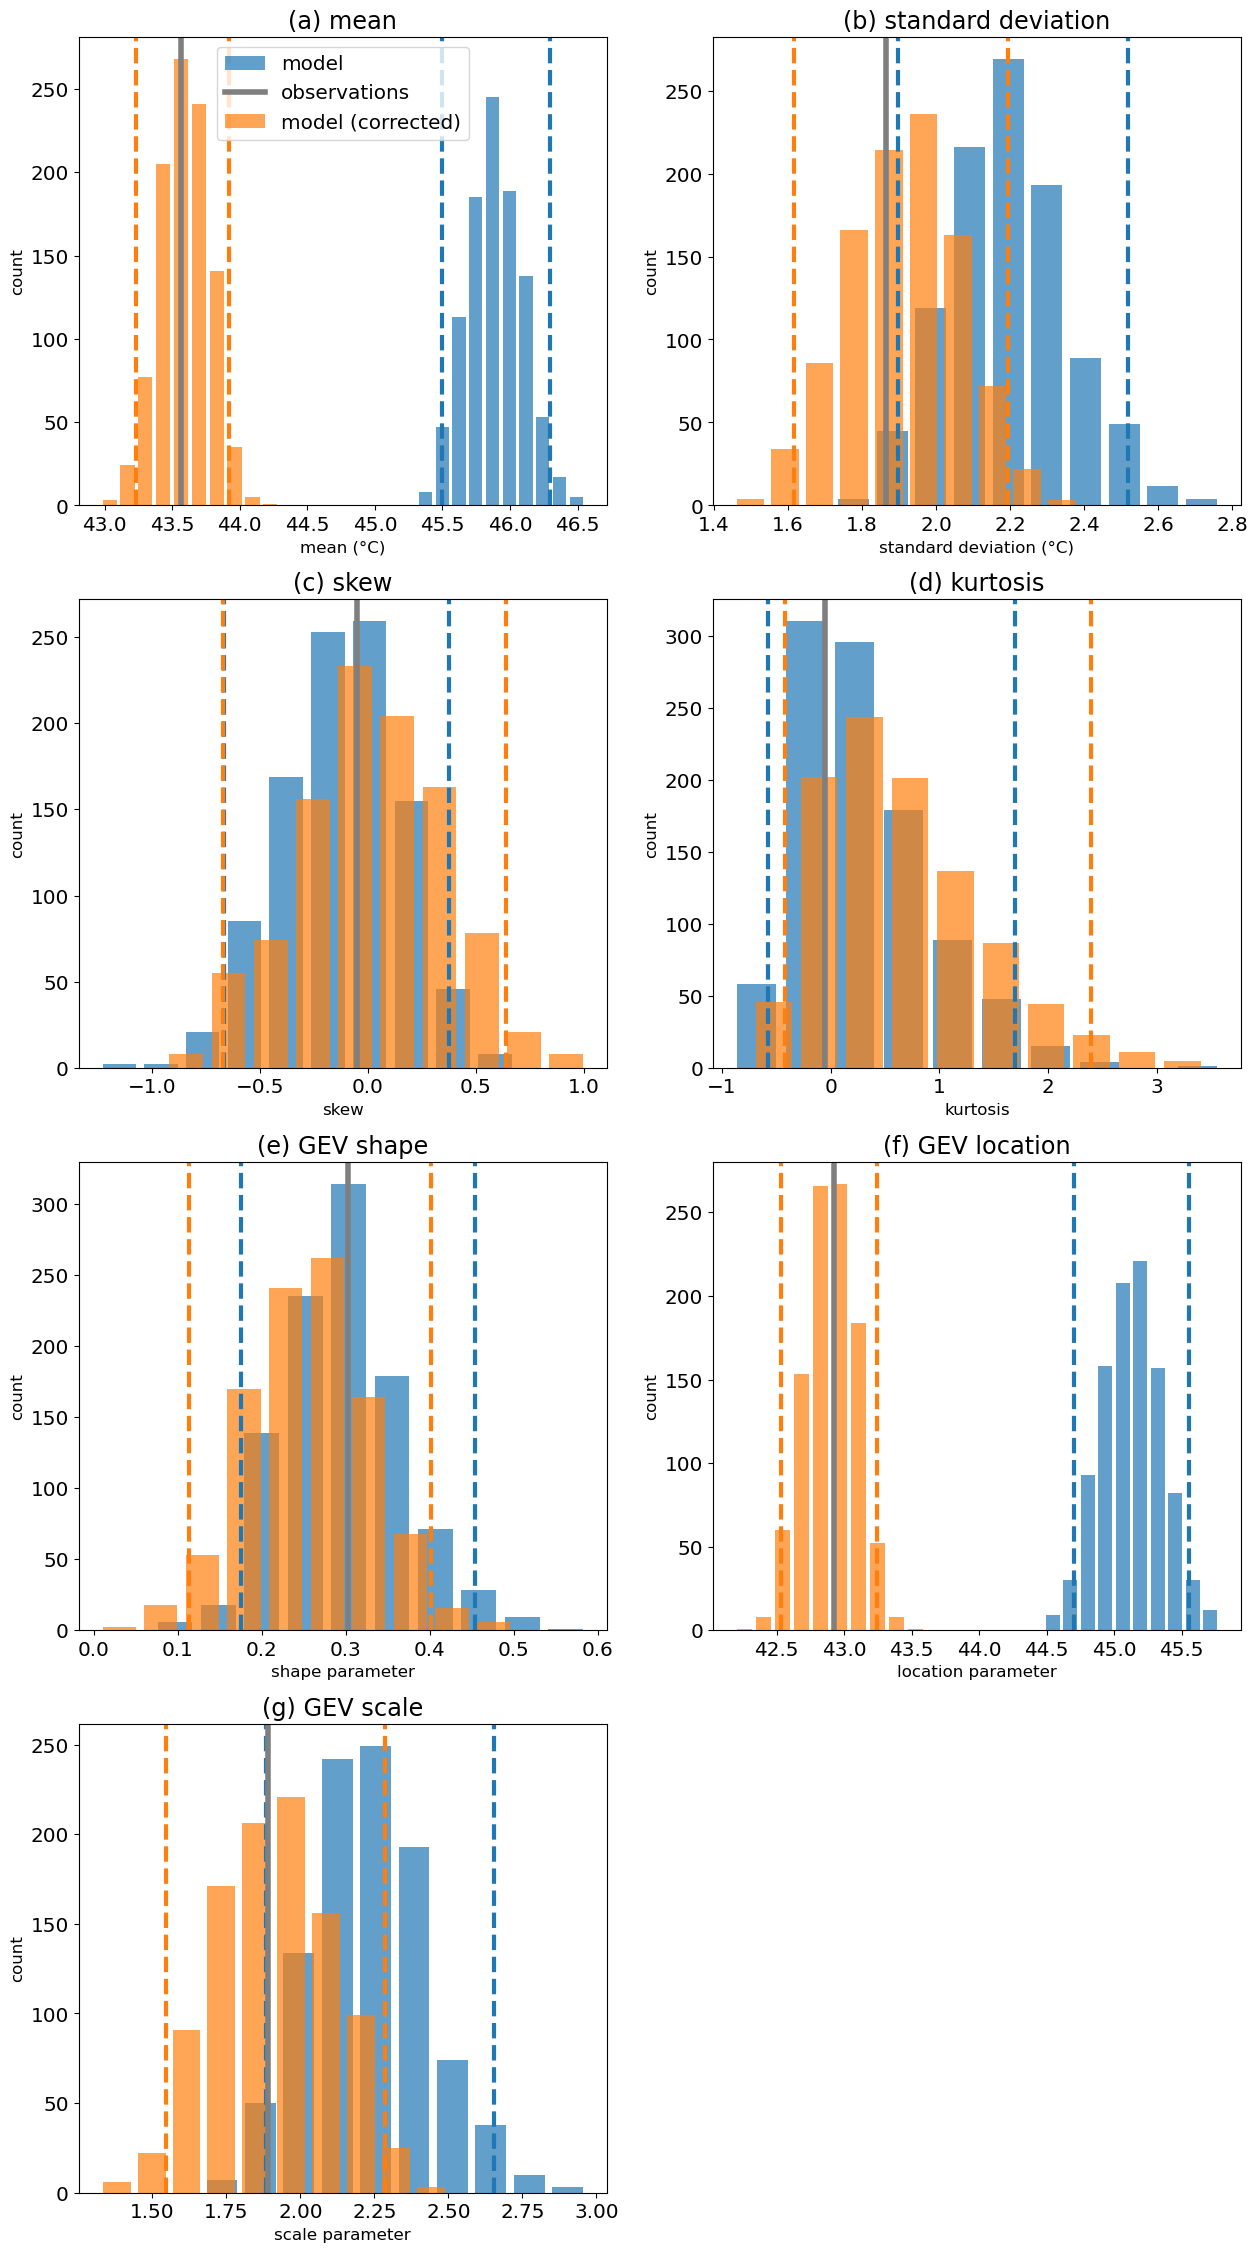

In [50]:
fidelity_tests(da_model_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.041802514
KS p-value: 0.9851255
AD score: -1.0411602
AD p-value: 0.25


INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.46516075134277 to 46.31442527770996
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.898529314994812 to 2.528863900899887
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.6919478431344033 to 0.4225774921476838
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.5687188982963562 to 1.7983043551445002
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.1545921608316891 to 0.43321807698404274
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      flo

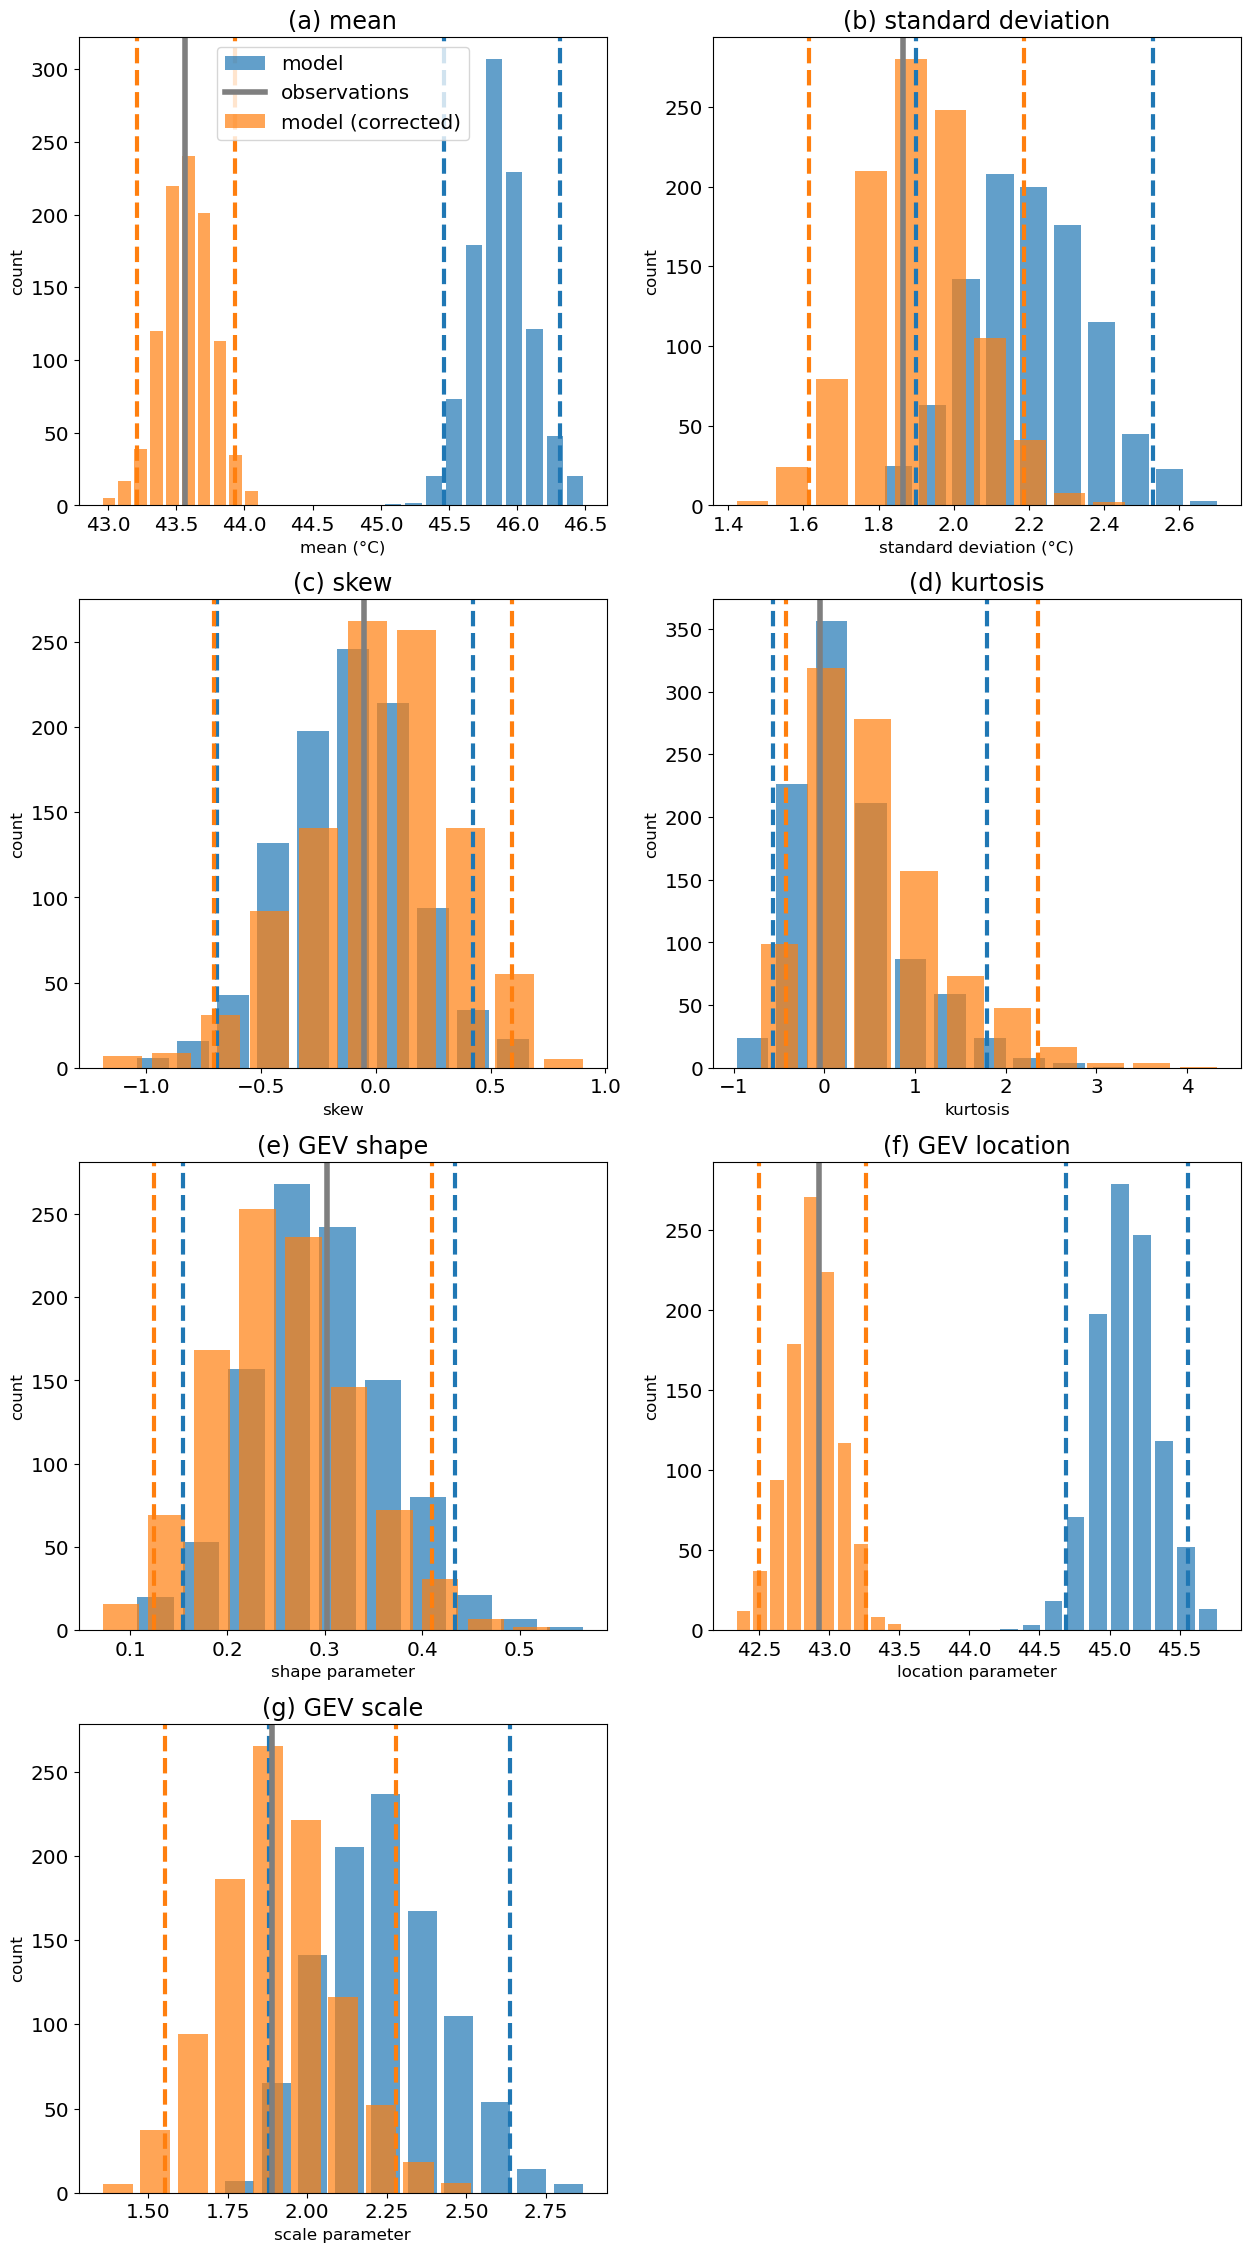

In [51]:
fidelity_tests(da_model_bc_quantile_mulc.unstack())